In [2]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt

import os ,sys, platform
import time
import cosmopower as cp

import mpi4py
import cobaya
from cobaya import run

#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi #time 

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Cosmo_Power(omb,omc,h,tau,ns,As): #function for single value cosmopower
    DET = 'TT'
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    reference = [omb,omc,h,tau,ns,As,chi]
    return chi #parameter, prediction , chi value

def cobaya_com(Dpar):
    return (10 - np.log(Cosmo_Power(Dpar,0.12,68,0.0546,0.964,2.01)))

In [2]:
cobaya_com(0.0223)

3.1836827568216526

In [50]:
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo": cobaya_com}}
info["params"] = {
    "Dpar": {"prior": {"min": 0.001, "max": 0.08}, "ref": 0.03, "proposal": 0.005},}
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}

In [51]:
from cobaya import run
updated_info, sampler = run(info)

[cosmo] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: Dpar:0.03
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {cosmo: 167.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-02-19 22:41:58 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 0.593
[mcmc]  - Convergence of means: R-1 = 3.068206 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cobaya\collection.py:651: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([


[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.646
[mcmc]  - Convergence of means: R-1 = 0.460704 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.457
[mcmc]  - Convergence of means: R-1 = 0.657712 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.366
[mcmc]  - Convergence of means: R-1 = 0.105304 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 200 samples accepted.
[mcmc]  - Acceptance rate: 0.321
[mcmc]  - Convergence of means: R-1 = 0.065210 after 160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.302
[mcmc]  - Convergence of means: R-1 = 0.006148 after 192 a

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
[root] *WARNING* outlier fraction 0.029166666666666667 
(1920,)


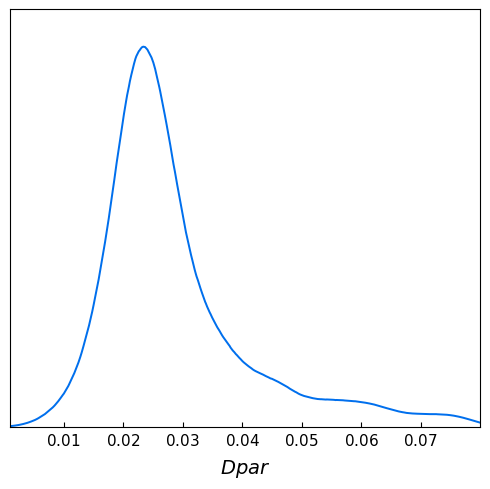

In [52]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["Dpar"], filled=True)
print(np.shape(gdsamples[1]))

In [53]:
print(gdsamples.samples[np.argmin(gdsamples.loglikes)])

[ 0.02333034 -6.42581776 -6.42581776]


In [27]:
def cobaya_com6(omb,omc,h,tau,ns,AS):
    return (10 - np.log(Cosmo_Power(omb,omc,h,tau,ns,AS)))

In [ ]:
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo1": cobaya_com1}}
info["params"] = {
   "omb": {"prior": {"min": 0.001, "max": 0.08}, "ref": 0.022, "proposal": 0.005},
    "omc": {"prior": {"min": 0, "max": 0.5}, "ref": 0.12, "proposal": 0.05},
    "h": {"prior": {"min": 50, "max": 80}, "ref": 66, "proposal": 0.5},
    "tau": {"prior": {"min": 0.01, "max": 0.06}, "ref": 0.054, "proposal": 0.005},
    "ns": {"prior": {"min": 0.3, "max": 1.5}, "ref": 0.945, "proposal": 0.005},
    "AS": {"prior": {"min": 1.5, "max": 2.5}, "ref": 2.0196, "proposal": 0.001}}
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.01, "max_tries": 1000}}
updated_info, sampler = run(info)

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
(488640,)


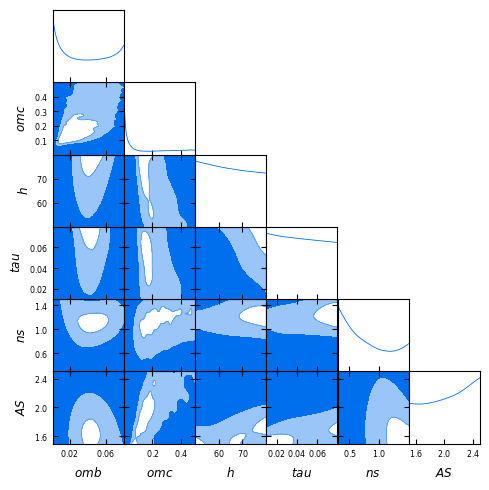

In [31]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["omb","omc","h","tau","ns","AS"], filled=True)
print(np.shape(gdsamples[6]))

In [3]:
def cobaya_com2(omb,omc):
    return (10-np.log(Cosmo_Power(omb,omc,66.78,0.0554,0.945,2.096)))
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo1": cobaya_com2}}
info["params"] = {
   "omb": {"prior": {"min": 0.001, "max": 0.03}, "ref": 0.022, "proposal": 0.001},
    "omc": {"prior": {"min": 0.01, "max": 0.4}, "ref": 0.12, "proposal": 0.01},
    
    }
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.0001, "max_tries": 1000}}
st = time.time()
updated_info, sampler = run(info)
et = time.time()
print(time_hr(et-st))

[cosmo1] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: omb:0.022, omc:0.12
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {cosmo1: 42.4}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-02-20 22:04:55 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.587
[mcmc]  - Convergence of means: R-1 = 2.739715 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cobaya\collection.py:651: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([


[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.590
[mcmc]  - Convergence of means: R-1 = 0.623176 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.438
[mcmc]  - Convergence of means: R-1 = 0.201892 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.364
[mcmc]  - Convergence of means: R-1 = 0.058420 after 256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 400 samples accepted.
[mcmc]  - Acceptance rate: 0.305
[mcmc]  - Convergence of means: R-1 = 0.046838 after 320 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.280
[mcmc]  - Convergence of means: R-1 = 0.103766 after 38

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
(27520,)


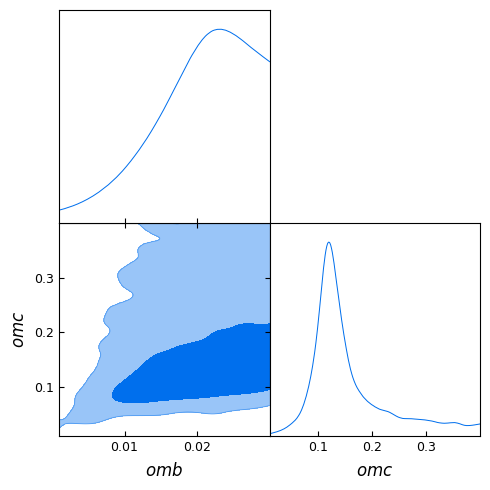

In [4]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["omb","omc"], filled=True)
print(np.shape(gdsamples[2]))

In [5]:
print(gdsamples.samples[np.argmin(gdsamples.loglikes)])

[ 0.02209514  0.1199604  -6.96444065 -6.96444065]


In [44]:
def cobaya_com3(omb,omc,h):
    return (10-np.log(Cosmo_Power(omb,omc,h,0.0554,0.945,2.096)))

In [45]:
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo1": cobaya_com3}}
info["params"] = {
   "omb": {"prior": {"min": 0.001, "max": 0.03}, "ref": 0.022, "proposal": 0.005},
    "omc": {"prior": {"min": 0.01, "max": 0.4}, "ref": 0.12, "proposal": 0.05},
    "h": {"prior": {"min": 30, "max": 90}, "ref": 66, "proposal": 0.05},
    }
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.0001, "max_tries": 1000}}
st = time.time()
updated_info, sampler = run(info)
et = time.time()
print(time_hr(et-st))

[cosmo1] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: omb:0.022, omc:0.12, h:66
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {cosmo1: 191.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-02-19 22:07:57 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.345
[mcmc]  - Convergence of means: R-1 = 3.640776 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cobaya\collection.py:651: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([


[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.376
[mcmc]  - Convergence of means: R-1 = 4.950298 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 360 samples accepted.
[mcmc]  - Acceptance rate: 0.338
[mcmc]  - Convergence of means: R-1 = 5.190239 after 288 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.327
[mcmc]  - Convergence of means: R-1 = 1.356299 after 384 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 600 samples accepted.
[mcmc]  - Acceptance rate: 0.299
[mcmc]  - Convergence of means: R-1 = 0.185294 after 480 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 720 samples accepted.
[mcmc]  - Acceptance rate: 0.295
[mcmc]  - Convergence of means: R-1 = 0.149190 after 57

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
(156600,)


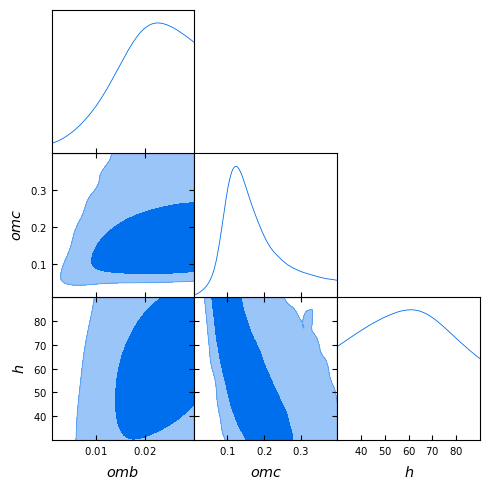

In [46]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["omb","omc","h"], filled=True)
print(np.shape(gdsamples[3]))

In [8]:
print(gdsamples.samples[np.argmin(gdsamples.loglikes)])
'''omb = 2.21288666e-02 = 0.02212886
omc =   1.20355924e-01 = 0.120355924
H =   6.66347140e+01 = 66.6347'''

[ 0.02209514  0.1199604  -6.96444065 -6.96444065]
